## Notes from last meeting

Date: 16/10/2023

Participants:

    Juan Manuel Morales
    Colin Torney
    Mercedes Soledad Burgueno
    Francis Felici

Objective: Discuss initial models for decoding accelerometer and magnetometer signals from wearable collars on sheep in Patagonia.


1. Calibration:

    Magnetometer Calibration:
        There's concern about the magnetometer data varying depending on the location.
        Without calibration, an accurate reading of head pitch is not achievable.
        Dataset annotated by Mercedes is from a different location than the one annotated by Sofía (although locations are close). Collars from both datasets were calibrated.

    Gravity:
        Ensure that gravity is subtracted from each accelerometer axis.

2. Feature Engineering and Usefulness:

    Head Pitch:
        The neural net cannot compute head pitch solely based on the axes due to missing information (was it time?).
        It was suggested to include head pitch as it provides valuable information, unlike the VeDBA which might not add new information.

    Roll and Gyroscope:
        Our devices lack a gyroscope, which is essential to compute `roll.angle`. This means the `roll.angle` data might just be random and not useful.
        Colin believes the `pitch.angle` may also require a gyroscope, though without it, an approximation might be possible (same thing with `roll.angle`). However, using the same model in a different location without a gyroscope may be problematic.

    VeDBA: Its addition was mentioned, but there's a concern it might be redundant information leading to potential overfitting.

3. Feature Scaling and Normalization:

    Concerns with Min-Max Scaling:
        We should avoid min-max scaling as there isn't a clear minimum or maximum value.
        If min-max scaling is done per split, the scales would vary, leading to inconsistencies between training and test data.

    Feature Normalization:
        A difference of 2 orders of magnitude or two standard deviations (SD) between features indicates the need for normalization or standardization.
        Histograms of features (without differentiating between sheep or behavior) should be plotted to evaluate the magnitude of feature differences.
        The neural network is theoretically capable of learning feature scales. However, due to current limitations in optimizers, it's preferable to scale features manually.

4. Data Preparation and Model Training:

    Data Splitting:
        It's important to ensure there's no data leakage from the test set to the training set.
        When splitting the training set, information from the labels shouldn't be used.

    Label Encoding:
        Utilize classic label vectors, e.g., [0, 1, 0, 0] for representing the four behaviors during model training.

    Segmentation and Sequence Length:
        Segments of sequences fed into the CNN-Transformer should be consecutive.
        While 5 seconds is standard for neural nets, 6.4 seconds was chosen due to limitations of the transformer architecture.

5. Uncertainty quantification:

    Confusion Matrix:
        Can be used to estimate uncertainties or measurement errors for each behavior. This differs from accuracy.
    QQ Plots:
        QQ Plots can be used as well. 


This notebook will explore the dataset to decide if it's needed to do feature normalization, based on big is the difference between the magnitude of the features.  
To accomplish this, we will build histograms of each of the features, without differentiating between sheep number.  


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
import math
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

In [53]:
#Load data
data = pd.read_csv('../data/filtered_clean_sheep_data_2019.csv')

data

,Unnamed: 0,sheep_name,sheep_number,year,month,day,hours,minutes,seconds,event.no.,...,mag_y,mag_z,pitch.angle,roll.angle,behaviours,video_name,video_number,file_name_original,date_time,hms
0,159,ov1.,1,2019,9,24,14,54,1,68383295,...,0.095215,-0.114258,-60.769377,24.152,eating,video21,21,/home/franfram/AAR-DL/data/sep/sep_video21_ov1...,2019-09-24T14:54:01Z,14:54:01
1,160,ov1.,1,2019,9,24,14,54,1,68383296,...,0.095215,-0.114258,-67.091824,18.790,eating,video21,21,/home/franfram/AAR-DL/data/sep/sep_video21_ov1...,2019-09-24T14:54:01Z,14:54:01
2,161,ov1.,1,2019,9,24,14,54,1,68383297,...,0.100830,-0.116211,-68.908686,4.580,eating,video21,21,/home/franfram/AAR-DL/data/sep/sep_video21_ov1...,2019-09-24T14:54:01Z,14:54:01
3,162,ov1.,1,2019,9,24,14,54,1,68383298,...,0.100830,-0.116211,-64.018771,-5.298,eating,video21,21,/home/franfram/AAR-DL/data/sep/sep_video21_ov1...,2019-09-24T14:54:01Z,14:54:01
4,163,ov1.,1,2019,9,24,14,54,1,68383299,...,0.100830,-0.116211,-57.430081,4.518,eating,video21,21,/home/franfram/AAR-DL/data/sep/sep_video21_ov1...,2019-09-24T14:54:01Z,14:54:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625102,849910,ov60,60,2019,9,24,15,45,59,69901432,...,0.059082,-0.167236,-34.465497,-13.764,eating,video31,31,/home/franfram/AAR-DL/data/sep/sep_video31_ov6...,2019-09-24T15:45:59Z,15:45:59
625103,849911,ov60,60,2019,9,24,15,45,59,69901433,...,0.059082,-0.167236,-31.814337,-11.088,eating,video31,31,/home/franfram/AAR-DL/data/sep/sep_video31_ov6...,2019-09-24T15:45:59Z,15:45:59
625104,849912,ov60,60,2019,9,24,15,45,59,69901434,...,0.059082,-0.167236,-28.483887,-13.912,eating,video31,31,/home/franfram/AAR-DL/data/sep/sep_video31_ov6...,2019-09-24T15:45:59Z,15:45:59
625105,849913,ov60,60,2019,9,24,15,45,59,69901435,...,0.065430,-0.170166,-28.425806,-23.728,eating,video31,31,/home/franfram/AAR-DL/data/sep/sep_video31_ov6...,2019-09-24T15:45:59Z,15:45:59


## Histograms of features

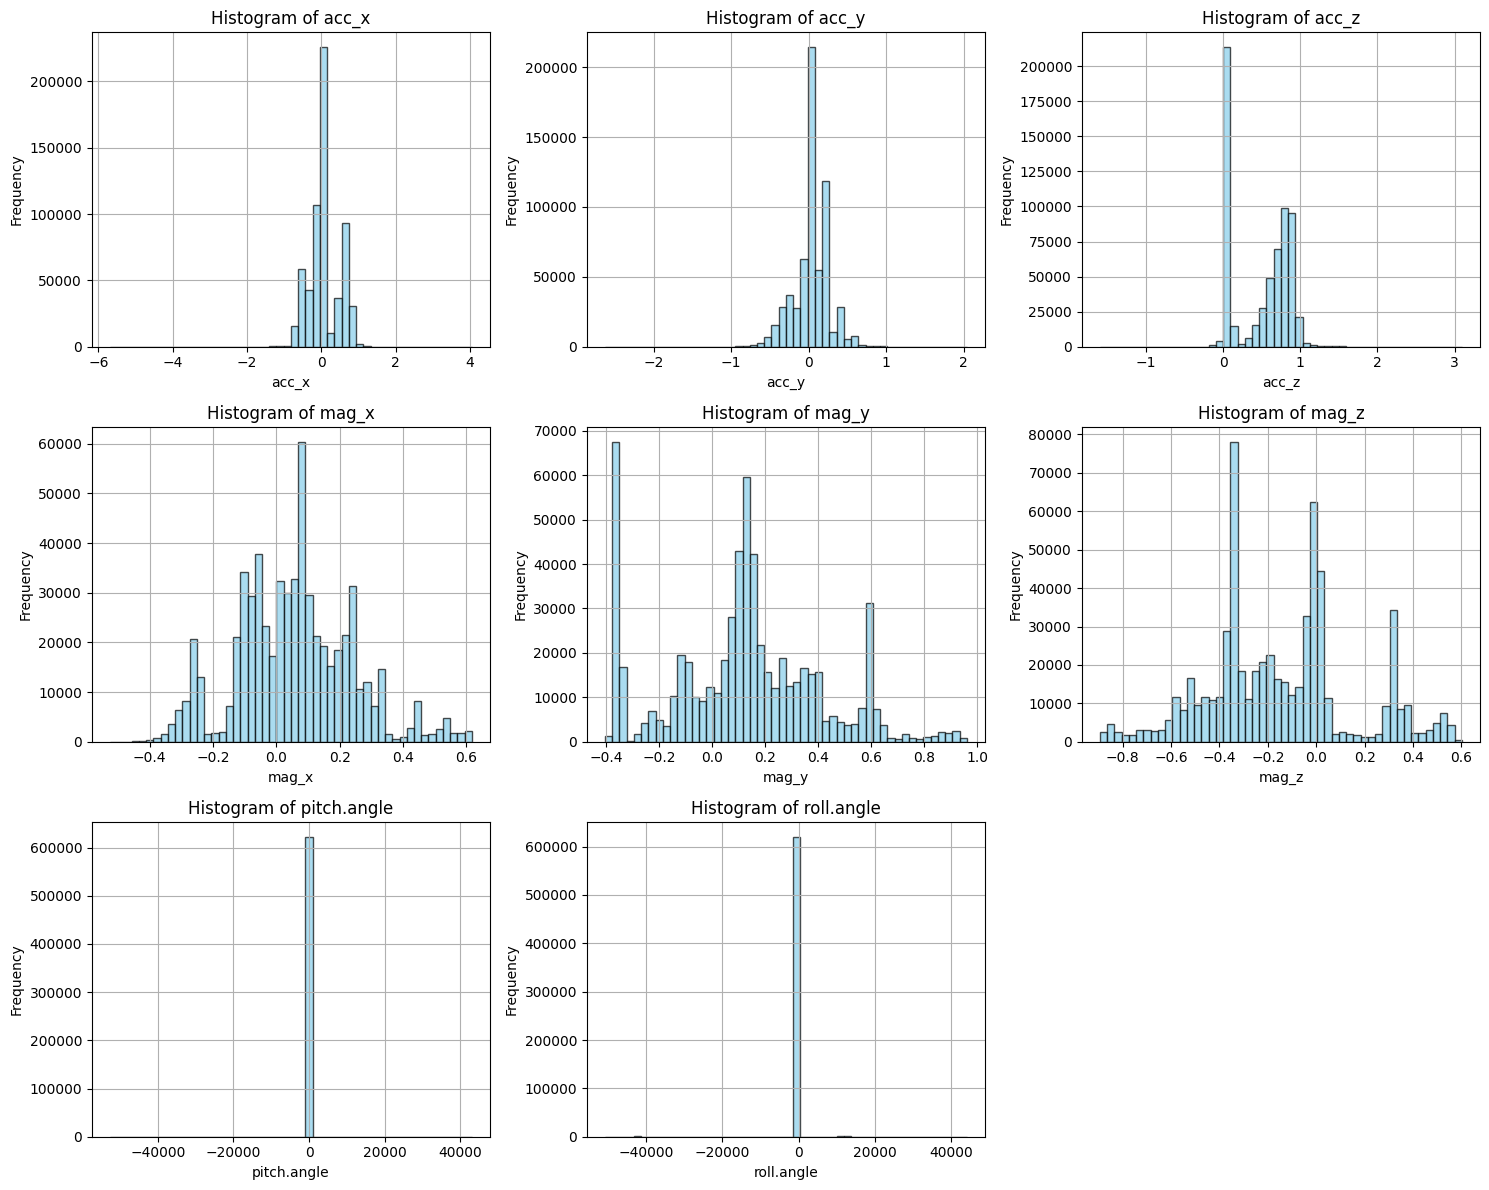

In [54]:
# List of features to plot histograms for
features = ['acc_x', 'acc_y', 'acc_z', 'mag_x', 'mag_y', 'mag_z', 'pitch.angle', 'roll.angle']

# Plotting histograms
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    data[feature].hist(bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Note that the `pitch.angle` and `roll.angle` histograms are show a single huge bin at 0 and the range is huge (+-40k). This indicates that the majority of values for those features are concentrated on a narrow range around 0, and that there are some very extreme values. 
This is evidenced by the descriptive statistics of those features: 

In [55]:
stats = data[['pitch.angle', 'roll.angle']].describe()

stats

,pitch.angle,roll.angle
count,625107.000000,625107.000000
mean,-127.810355,-31.442949
std,1723.022023,2069.054376
min,-52654.000000,-50768.000000
25%,-40.257479,-13.110000
50%,-5.878782,-0.876000
75%,22.863847,18.592000
max,43056.000000,44106.000000


And now let's check all the quantiles for a more detailed view of the distribution of the data: 

In [56]:
print(f"pitch angle: \n {data['pitch.angle'].quantile([i/10 for i in range(11)])}"), print(f"\n roll angle: \n {data['roll.angle'].quantile([i/10 for i in range(11)]) }\n")

pitch angle: 
 0.0   -52654.000000
0.1      -48.579351
0.2      -42.747152
0.3      -37.651540
0.4      -28.114154
0.5       -5.878782
0.6        8.357394
0.7       16.117978
0.8       28.064427
0.9       38.718720
1.0    43056.000000
Name: pitch.angle, dtype: float64

 roll angle: 
 0.0   -50768.000
0.1      -24.568
0.2      -14.682
0.3      -12.086
0.4       -9.404
0.5       -0.876
0.6        9.232
0.7       14.036
0.8       24.568
0.9       33.918
1.0    44106.000
Name: roll.angle, dtype: float64



(None, None)

The extreme values highlighted in the quantile results for the features `pitch.angle`, and `roll.angle`, are likely to be outliers or errors in the data collection process. Given the nature of these readings, such extreme values are usually not realistic.

A common approach to detect and filter out extreme values is the Interquartile Range (IQR) method. Here's how it works:

- Compute the 25th (Q1) and 75th (Q3) percentiles of the data.
- Calculate the IQR: $IQR=Q3−Q1$
- Determine the lower and upper bounds for outliers:
    - Lower Bound: Q1−1.5×IQR   
    - Upper Bound: Q3+1.5×IQR 
- Filter out values that are outside the bounds.

We will apply the IQR method to filter out extreme values for the features pitch.angle, and roll.angle. We have to keep in mind that the IQR method works well for features that have approximately symmetric distributions. However, given the evident skewness in some of your features, we might want to adjust the multiplier (1.5 in the above steps) to be more or less stringent based on your domain knowledge and the specific feature distribution, but we will leave this for later. 


In [57]:
def filter_outliers_using_iqr(data, column, multiplier=1.5):
    """
    Filter out outliers in a DataFrame column using the IQR method.

    Parameters:
    - data: DataFrame containing the data
    - column: Column name to be filtered
    - multiplier: Multiplier for the IQR to define bounds (default is 1.5)
    
    Returns:
    - Filtered DataFrame
    """
    # Compute the IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Determine bounds
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Filter out outliers
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)][column]

# Filter data using IQR method for the three features
filtered_pitch_angle = filter_outliers_using_iqr(data, 'pitch.angle')
filtered_roll_angle = filter_outliers_using_iqr(data, 'roll.angle')
filtered_acc_x = filter_outliers_using_iqr(data, 'acc_x')

# Display the number of rows before and after filtering for each feature
original_rows = len(data)
filtered_rows_pitch_angle = len(filtered_pitch_angle)
filtered_rows_roll_angle = len(filtered_roll_angle)
filtered_rows_acc_x = len(filtered_acc_x)

original_rows, filtered_rows_pitch_angle, filtered_rows_roll_angle, filtered_rows_acc_x


for key, value in zip(['pitch.angle', 'roll.angle', 'acc_x'], [filtered_pitch_angle, filtered_roll_angle, filtered_acc_x]):
    print(f"Number of outliers in {key}: {original_rows - len(value)} --> percentage of rows removed: {(original_rows - len(value)) / original_rows * 100:.2f}%")

Number of outliers in pitch.angle: 3810 --> percentage of rows removed: 0.61%
Number of outliers in roll.angle: 9034 --> percentage of rows removed: 1.45%
Number of outliers in acc_x: 1367 --> percentage of rows removed: 0.22%


Let's now include them in the dataset and check the histograms again:

In [58]:
data['filtered_pitch_angle'] = filtered_pitch_angle
data['filtered_roll_angle'] = filtered_roll_angle


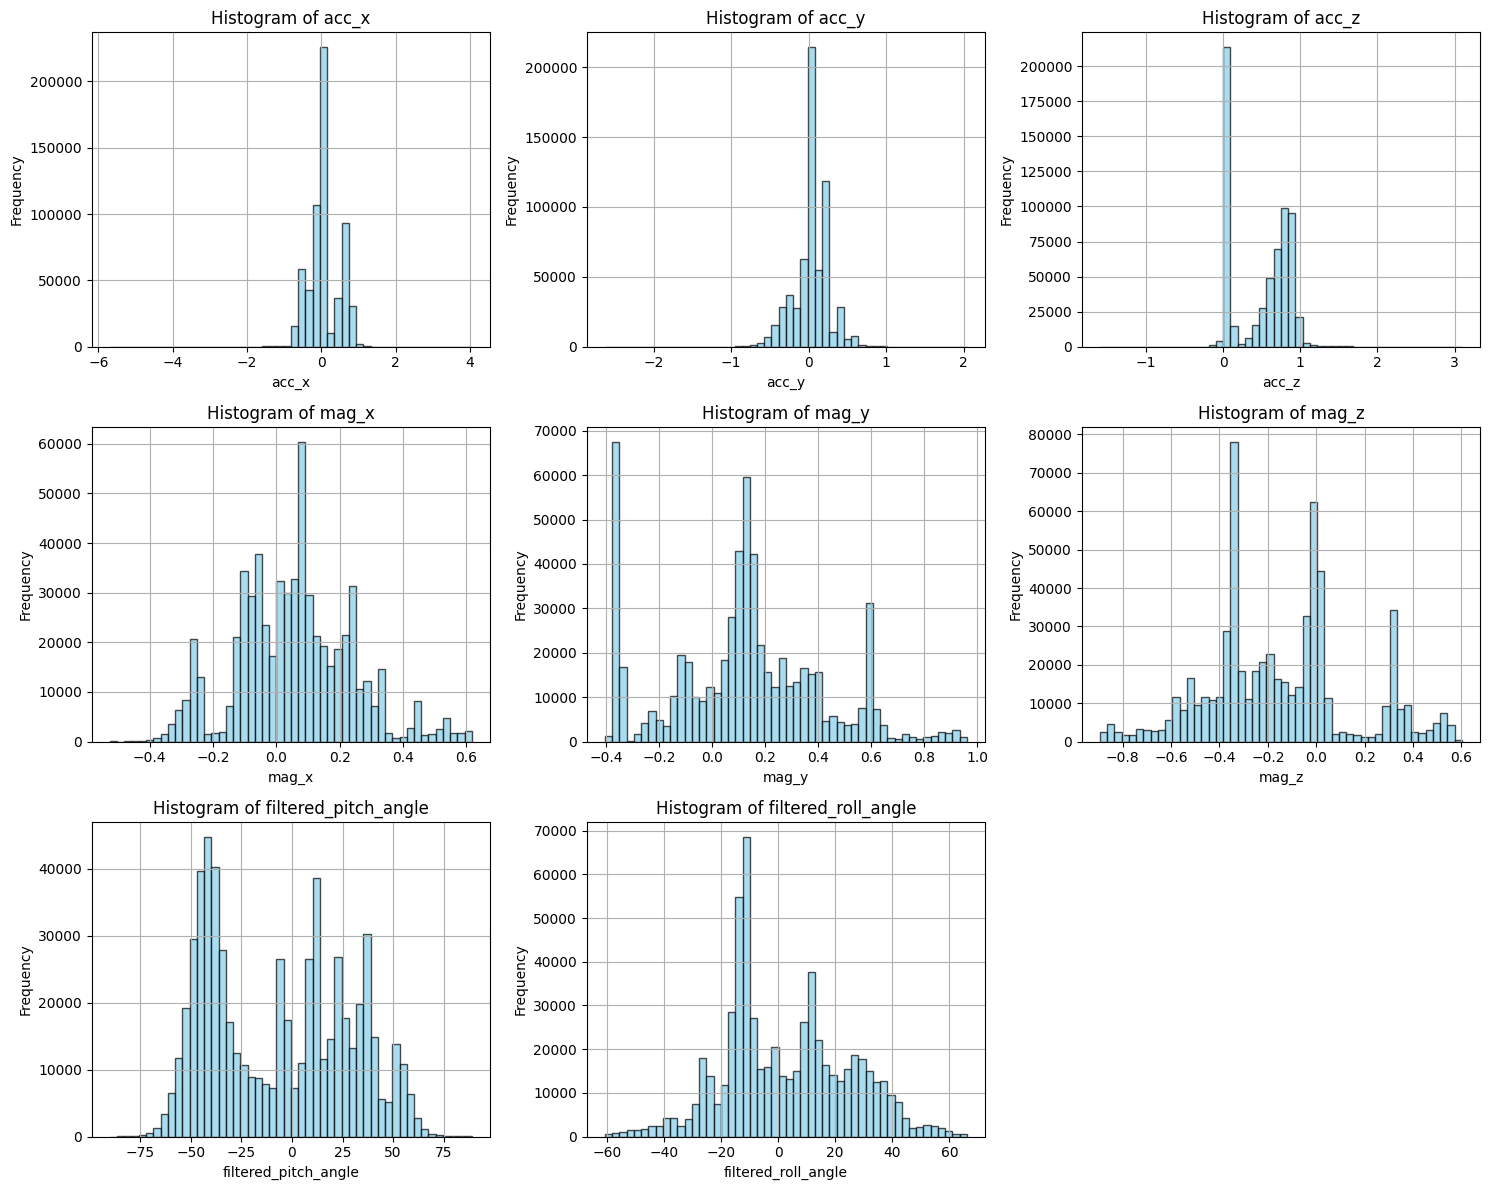

In [59]:
# features = ['acc_x', 'acc_y', 'acc_z', 'mag_x', 'mag_y', 'mag_z', 'pitch.angle', 'roll.angle']
features = ['acc_x', 'acc_y', 'acc_z', 'mag_x', 'mag_y', 'mag_z', 'filtered_pitch_angle', 'filtered_roll_angle']

# Plotting histograms
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    data[feature].hist(bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


We can now see the resulting histograms properly. We can see that the features `pitch.angle`, and `roll.angle` are two 2 orders of magnitude bigger than the rest of the features. This is a problem because the magnitude of the features will influence the results of the learning algorithms. Thus, we should normalize the features to bring them to the same scale.


Now let's plot the 
## Histograms per behaviour:

/tmp/ipykernel_12187/380592157.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_behaviours))


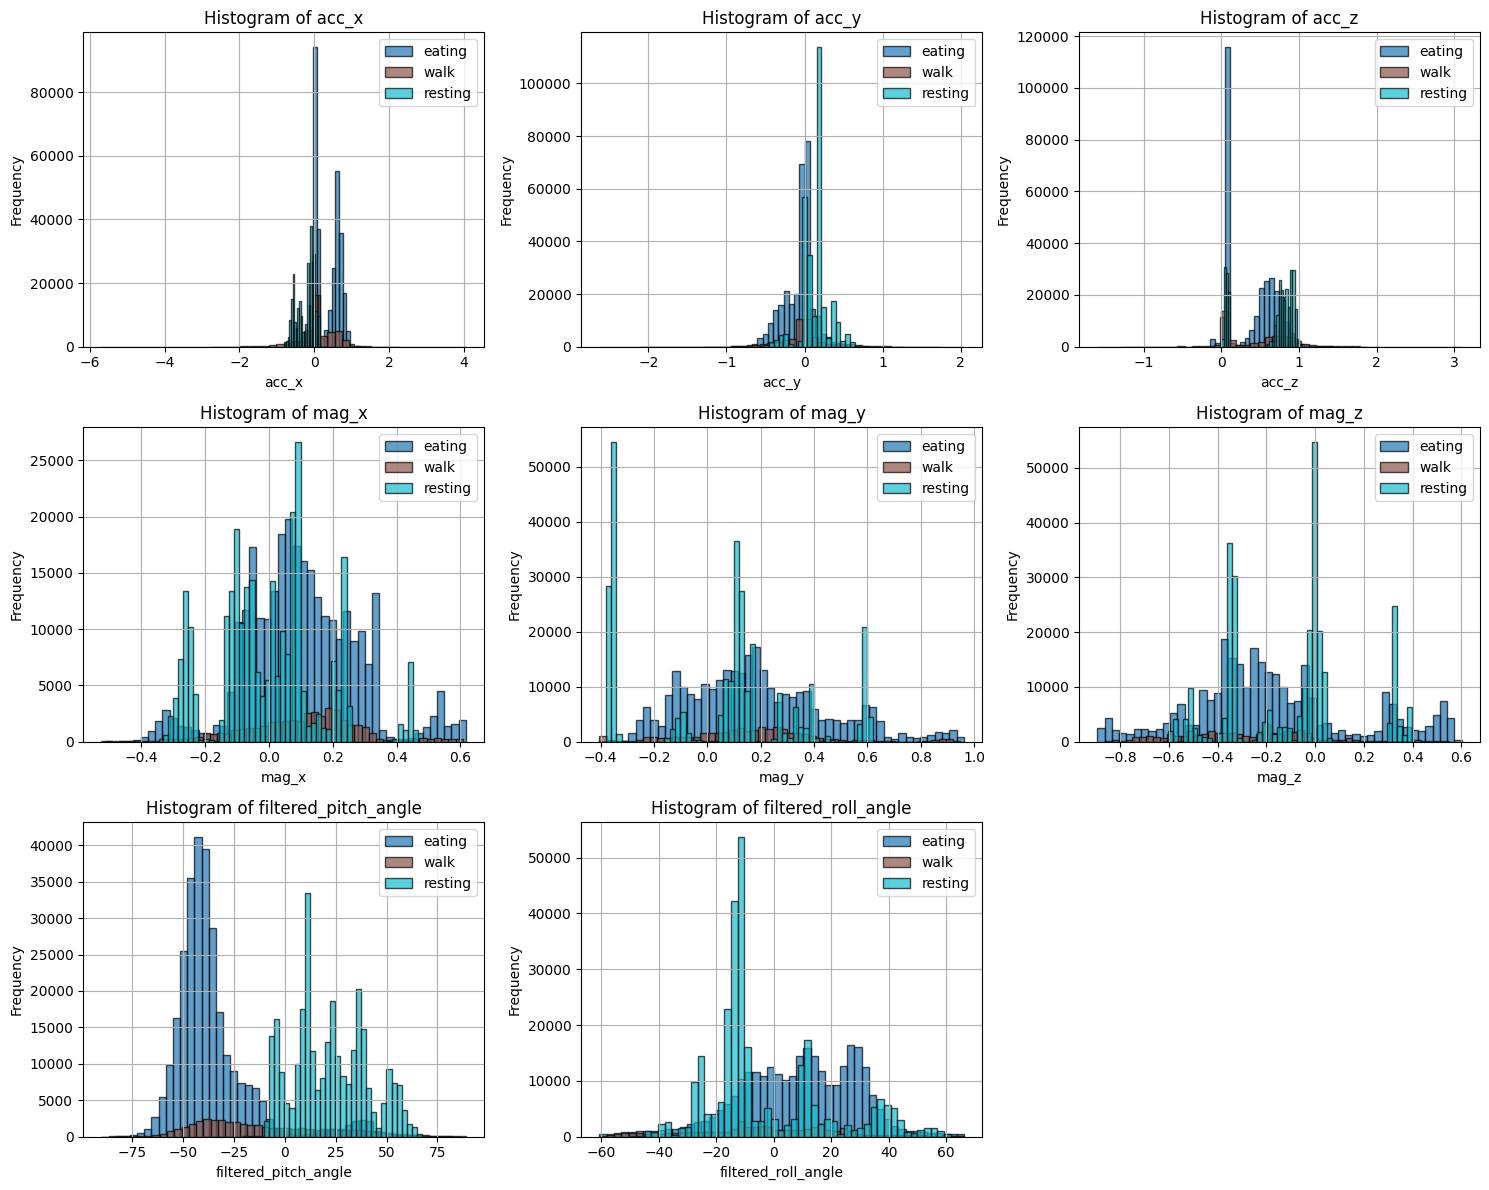

In [60]:
def plot_histograms_per_behaviour(data: pd.DataFrame, features: List[str]) -> None:
    """
    Plot histograms for each specified feature, differentiated by behaviours. 
    Each behaviour is represented by a different color in the histogram.

    Parameters:
    - data: DataFrame containing the data.
    - features: List of feature names to be plotted.
    
    Returns:
    None. Displays the histograms.
    """
    
    # Identify the unique behaviours and define a color map
    unique_behaviours = data['behaviours'].unique()
    color_map = plt.cm.get_cmap('tab10', len(unique_behaviours))

    # Calculate subplot dimensions based on th enumber of features
    total_features = len(features)
    num_cols = 3
    num_rows = math.ceil(total_features / num_cols) 

    # Set up the figure
    plt.figure(figsize=(15, num_rows * 4))
    
    # Loop through each feature
    for i, feature in enumerate(features, 1):
        plt.subplot(num_rows, num_cols, i)
        
        # Plot histogram for each behaviour
        for j, behaviour in enumerate(unique_behaviours):
            subset = data[data['behaviours'] == behaviour]
            subset[feature].hist(bins=50, color=color_map(j), edgecolor='black', alpha=0.7, label=behaviour)
        
        plt.title(f'Histogram of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Testing the function with the given features
plot_histograms_per_behaviour(data, features)

Okay, based on the distributions of behaviours per feature, the values don't seem super different so as that the neural net will be able to differentiate them. We will try to do some feature engineering by hand (include ODBA and VeDBA) to see if it improves. 


In [61]:
# Compute the Overall Dynamic Body Acceleration (ODBA) and Vectorial Dynamic Body Acceleration (VeDBA)
# Calculate the mean values for the accelerometer readings
mean_acc_x = data['acc_x'].mean()
mean_acc_y = data['acc_y'].mean()
mean_acc_z = data['acc_z'].mean()

# Compute ODBA
data['ODBA'] = abs(data['acc_x'] - mean_acc_x) + abs(data['acc_y'] - mean_acc_y) + abs(data['acc_z'] - mean_acc_z)

# Compute VeDBA
data['VeDBA'] = ((data['acc_x'] - mean_acc_x)**2 + (data['acc_y'] - mean_acc_y)**2 + (data['acc_z'] - mean_acc_z)**2)**0.5

new_features = ['ODBA', 'VeDBA']



/tmp/ipykernel_12187/380592157.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_behaviours))


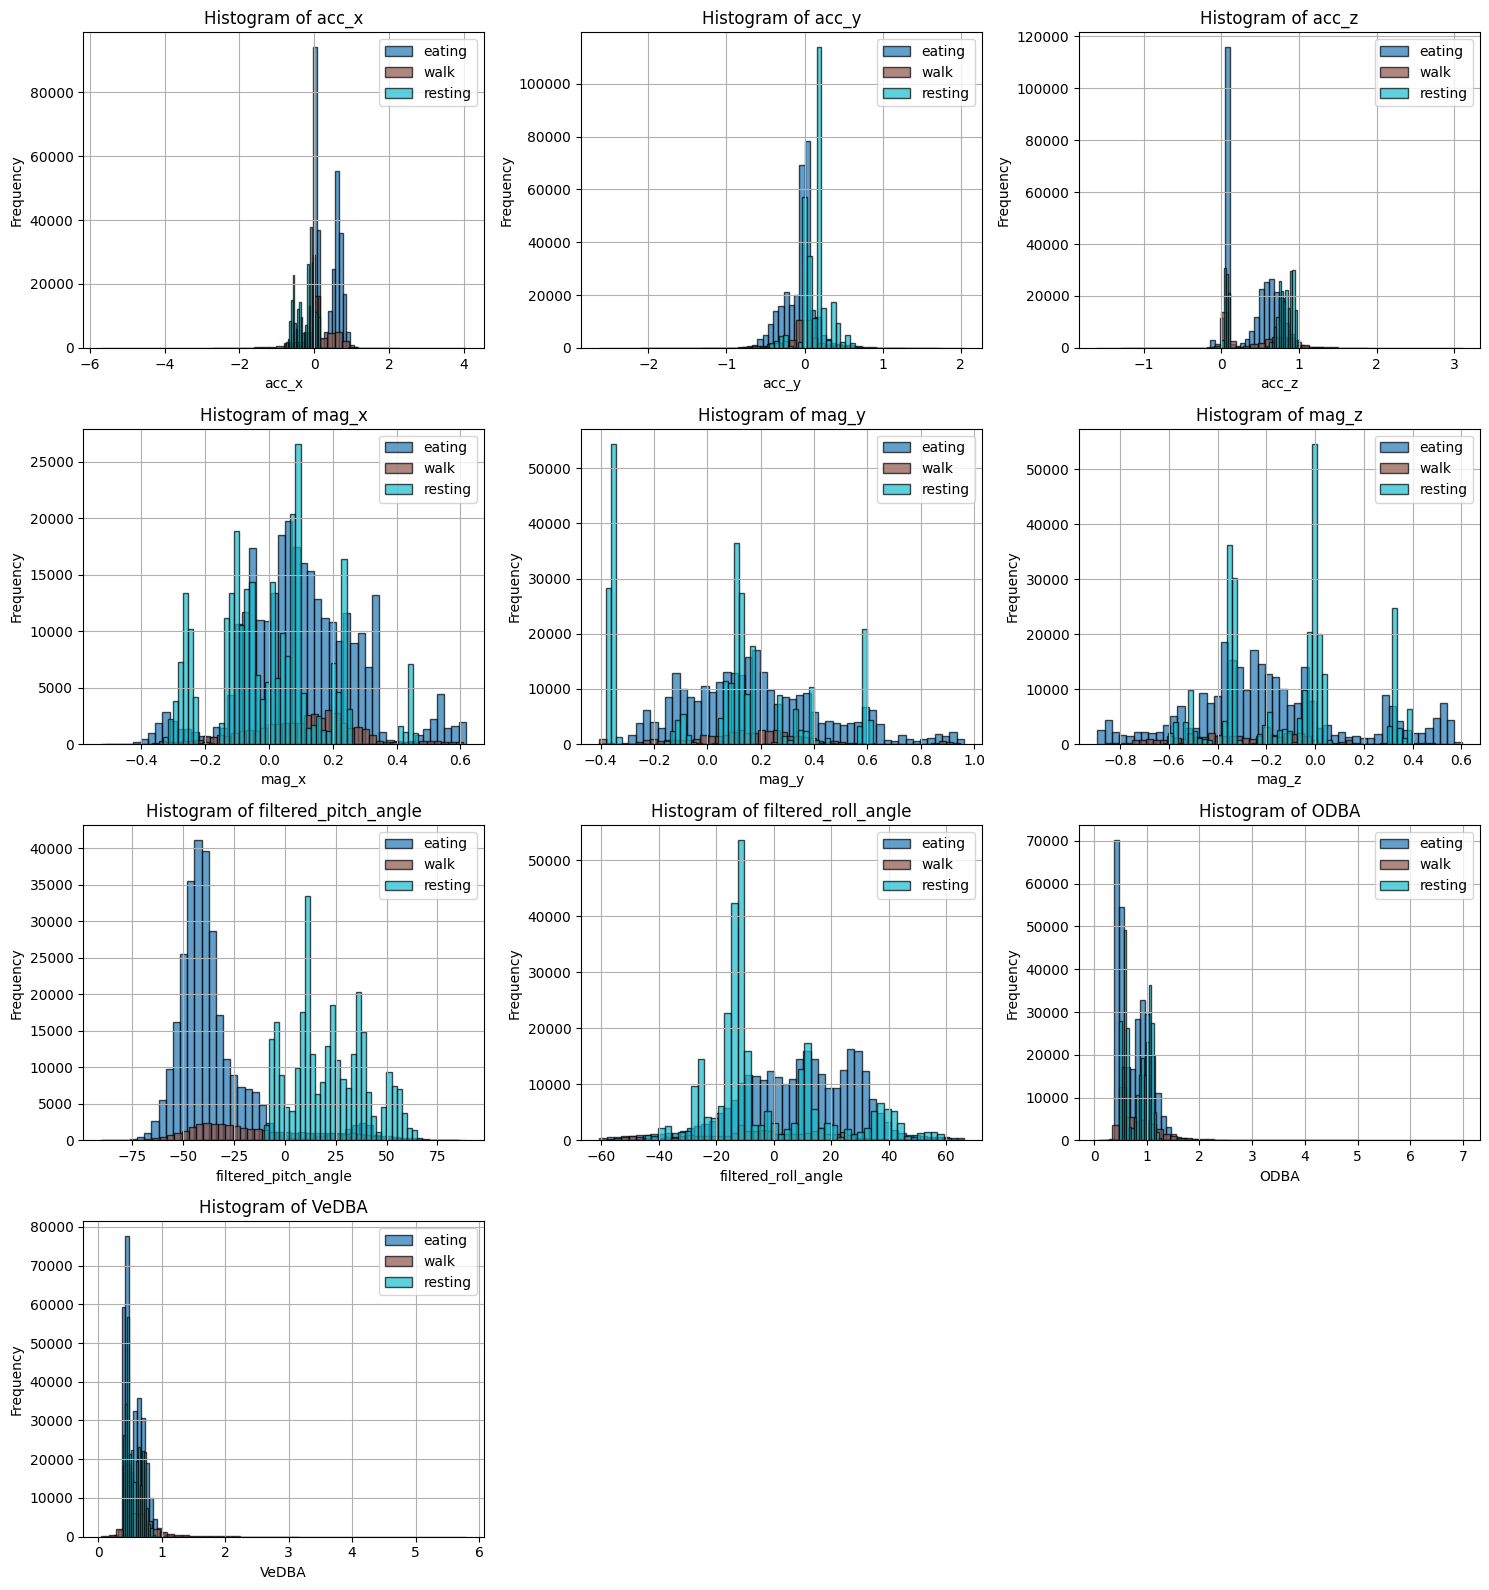

In [62]:
plot_histograms_per_behaviour(data, features + new_features)

## Testing other features




In [64]:
if 'old_columns' not in globals(): 
    old_columns = data.columns

In [65]:
# a. Rolling statistics: 
# window_sizes = [5, 10]
window_sizes = [10]
for window in window_sizes:
    # for feature in features + new_features: 
    for feature in features:
        data[f'{feature}_rolling_mean_{window}'] = data[feature].rolling(window=window).mean()
        # data[f'{feature}_rolling_var_{window}'] = data[feature].rolling(window=window).var()

# # b. Lagged features:
# for feature in features + new_features:
#     data[f'{feature}_lag_5'] = data[feature].shift(5)

# # c. Frequency-domain Features (Fast Fourier Transform): 
# for feature in features + new_features:
#     data[f'{feature}_ftt'] = np.fft.fft(data[feature])



In [66]:
new_columns = data.columns

In [67]:
very_new_features = list(new_columns.difference(old_columns))
very_new_features

['acc_x_rolling_mean_10',
 'acc_y_rolling_mean_10',
 'acc_z_rolling_mean_10',
 'filtered_pitch_angle_rolling_mean_10',
 'filtered_roll_angle_rolling_mean_10',
 'mag_x_rolling_mean_10',
 'mag_y_rolling_mean_10',
 'mag_z_rolling_mean_10']

/tmp/ipykernel_12187/380592157.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_behaviours))


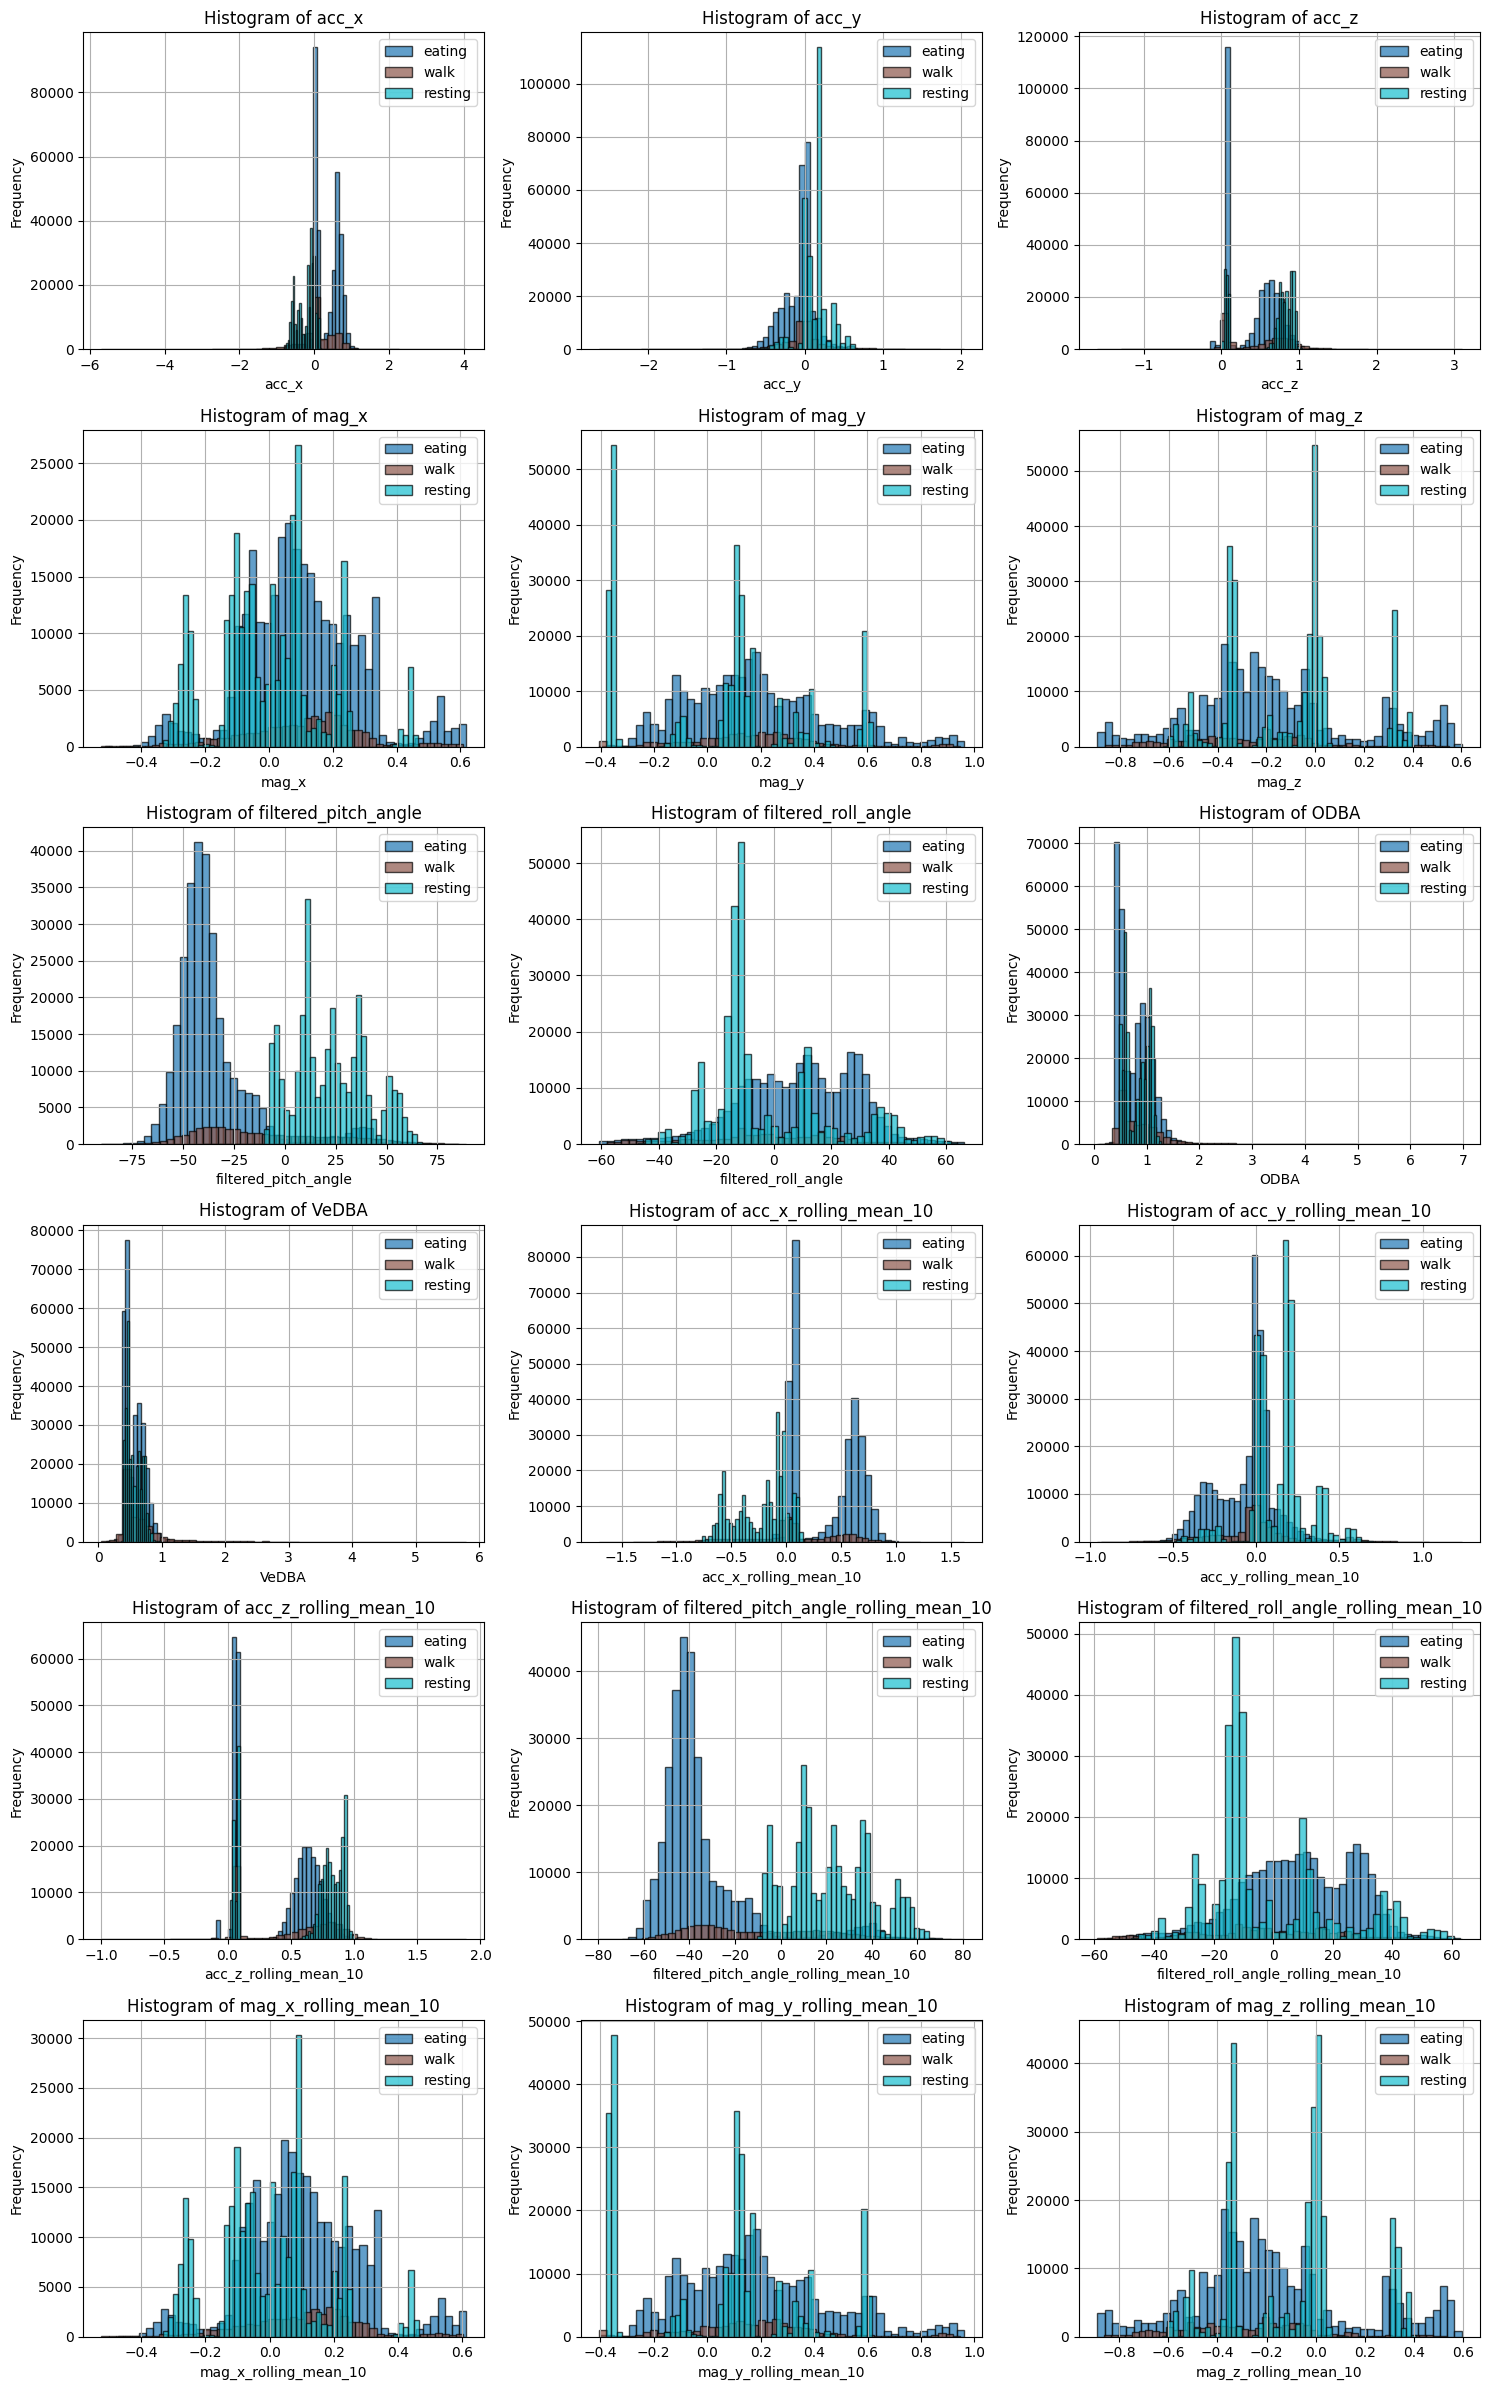

In [68]:
plot_histograms_per_behaviour(data, features + new_features + very_new_features)